<a href="https://colab.research.google.com/github/Chris-Manna/face_detector/blob/master/chris_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Recognition

##  Import Libraries and Connect to Drive

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Load Training Data

In [0]:
!mkdir data
!mkdir testing

mkdir: cannot create directory ‘testing’: File exists


In [0]:
cd data

/content/data/data


In [0]:
folder_id='1n594vxKEow-foVYScQeTh9vQSjJdZuIm'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

In [0]:
downloaded = drive.CreateFile({'id': '15F0UPe7aTMeaikYRKh9Fq6fix8XcXje5'})
downloaded.GetContentFile(downloaded['title'])



In [0]:
for file in file_list:
  downloaded = drive.CreateFile({'id': file['id']})
  downloaded.GetContentFile(downloaded['title'])

In [0]:
!zip -d 'face.zip' __MACOSX/\*
!zip -d 'not_face.zip' _MACOSX/\*

	zip warning: name not matched: __MACOSX/*

zip error: Nothing to do! (face.zip)
	zip warning: name not matched: _MACOSX/*

zip error: Nothing to do! (not_face.zip)


In [0]:
!unzip face.zip
!unzip not_face.zip

Archive:  face.zip
  inflating: face/9326871.1.jpg      
  inflating: face/Denzel_Washington_cropped.jpg  
  inflating: face/brad_pitt.jpg      
  inflating: face/brad_pitt_hair.jpg  
  inflating: face/chris_face.jpg     
  inflating: face/9336923.jpg        
  inflating: face/sbains.jpg         
  inflating: face/yfhsie.jpg         
  inflating: face/slbirc.jpg         
  inflating: face/vstros.jpg         
  inflating: face/phughe.jpg         
  inflating: face/astefa.jpg         
  inflating: face/asewil.jpg         
  inflating: face/lfso.jpg           
  inflating: face/klclar.jpg         
  inflating: face/drbost.jpg         
  inflating: face/mbutle.jpg         
  inflating: face/ksunth.jpg         
  inflating: face/ekavaz.jpg         
  inflating: face/kaknig.jpg         
  inflating: face/asamma.jpg         
  inflating: face/elduns.jpg         
  inflating: face/images.zip         
  inflating: face/9338535.jpg        
  inflating: face/anpage.jpg         
  inflating: face/

In [0]:
!rm face.zip
!rm not_face.zip
!rm -rf __MACOSX

In [0]:
#navigate back to /content
cd ..

/content/data


In [0]:
cd testing

/content/data/testing


In [0]:
#load testing examples
folder_id='1KhkMRFjctpmgoDdh5_fUJhbCvyY8tXwN'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

for file in file_list:
  downloaded = drive.CreateFile({'id': file['id']})
  downloaded.GetContentFile(downloaded['title'])

In [0]:
directory = 'data/'

In [0]:
#make sure you are in the content directory
cd ..

/content/data


In [0]:
print(len(os.listdir('data/face')))
print(len(os.listdir('data/not_face')))

3064
1377


## Preprocess Images

- Rotate images, change contrast to get pictures, 
- Find filter already geared towards identifying faces.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# get all the data in the directory split/test, and reshape them
ph_size = 128
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(ph_size, ph_size), 
        batch_size = 5000, 
        seed = 123) 

Found 4439 images belonging to 2 classes.


In [0]:
#split images and labels
images, labels = next(data_all)

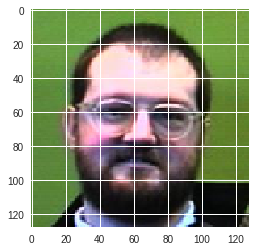

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[4])
plt.show()

In [0]:
#explore each r,g,b matrix
r_img = images[4][:,:,0]
g_img = images[4][:,:,1]
b_img = images[4][:,:,2]

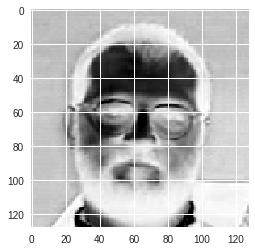

In [0]:
plt.imshow(b_img, plt.cm.binary)
plt.show()

In [0]:
len(labels)

4439

## 2. Densely connected network

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

In [0]:
#reshape into 1D arrays (only for densely connected network)
X = images.reshape(images.shape[0], -1)
y = np.reshape(labels[:,0], (len(labels),1))

In [0]:
#split model and test sets
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [0]:
#split validation and training sets from model split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

### Using PCA with Densely Connected Network
Components of a pixel are statistically correlated. 

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

##### Standardizing the Data

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train_img = scaler.transform(X_train)
X_val_img = scaler.transform(X_val)

##### Performing PCA

PCA to Speed up Machine Learning Algorithms (Logistic Regression)

In [0]:
pca = PCA(0.99)

pca.fit(X_train_img)


PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_dimensions = pca.n_components_

Reduced 128 x 128 x 3 = 49,152 pixel composition, running pca on this will give back 1104 principal components maintaining 99% variation

Q: What is the optimal number of components? 

In [0]:
X_train_img = pca.transform(X_train_img)
X_val_img = pca.transform(X_val_img)

In [0]:
X_train_img[0]

array([  9.607404  , -36.03283   , -95.16285   , ...,   0.93279   ,
        -0.2812826 ,  -0.39045185], dtype=float32)

### Now try using Densely Connected  Network

In [0]:
from keras.layers import LeakyReLU

dense = models.Sequential()
dense.add(layers.Dense(16, activation='tanh', input_shape=(pca_dimensions,))) #2 hidden layers
dense.add(LeakyReLU(alpha=0.05))
# dense.add(layers.Dense(4, activation='leakyrelu'))
# dense.add(layers.Dense(8, activation='LeakyRelu'))#,alpha=0.05)
dense.add(layers.Dense(1, activation='sigmoid'))

dense.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dense_fit = dense.fit(X_train_img,
                    y_train,
                    epochs=30,
                    batch_size=50,
                    validation_data=(X_val_img, y_val))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2840 samples, validate on 711 samples
Epoch 1/30
2840/2840 [==============================] - 2s 785us/step - loss: 0.4172 - acc: 0.8528 - val_loss: 0.2863 - val_acc: 0.9325
Epoch 2/30
2840/2840 [==============================] - 0s 86us/step - loss: 0.2413 - acc: 0.9567 - val_loss: 0.1980 - val_acc: 0.9662
Epoch 3/30
2840/2840 [==============================] - 0s 78us/step - loss: 0.1792 - acc: 0.9729 - val_loss: 0.1565 - val_acc: 0.9775
Epoch 4/30
2840/2840 [==============================] - 0s 76us/step - loss: 0.1466 - acc: 0.9803 - val_loss: 0.1289 - val_acc: 0.9845
Epoch 5/30
2840/2840 [==============================] - 0s 73us/step - loss: 0.1272 - acc: 0.9835 - val_loss: 0.1161 - val_acc: 0.9845
Epoch 6/30
2840/2840 [==============================] - 0s 72us/step - loss: 0.1120 - acc: 0.9856 - val_loss: 0.1027 - val_acc: 0.9845
Epoch 7/30
2840/2840 [

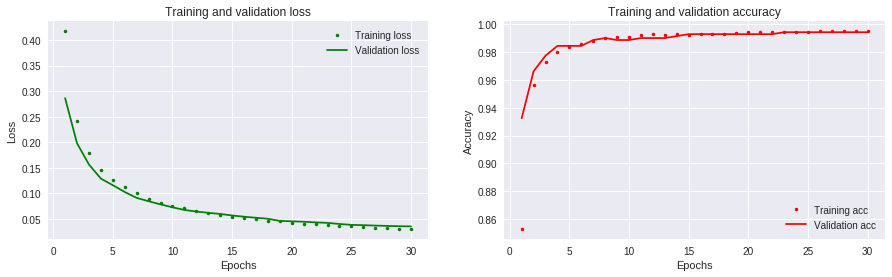

In [0]:
hist_dense = dense_fit.history
loss_values = hist_dense['loss']
val_loss_values = hist_dense['val_loss']
acc_values = hist_dense['acc'] 
val_acc_values = hist_dense['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
base = 'data/face/'
photo="Denzel_Washington_cropped.jpg"
path = base+photo

# pca.transform(path)
predictoneimage_dense_1(path)

NameError: ignored

### First Densely Connected Network - Epochs = 60

In [0]:

dense = models.Sequential()
dense.add(layers.Dense(16, activation='relu', input_shape=(ph_size*ph_size*3,))) #2 hidden layers
dense.add(layers.Dense(4, activation='relu'))
dense.add(layers.Dense(1, activation='sigmoid'))

dense.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dense_fit = dense.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val))

#### Visualize Training/Validation Loss and Acccuracy Across Epochs

In [0]:
hist_dense = dense_fit.history
loss_values = hist_dense['loss']
val_loss_values = hist_dense['val_loss']
acc_values = hist_dense['acc'] 
val_acc_values = hist_dense['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
results_train = dense.evaluate(X_train, y_train)

In [0]:
results_test = dense.evaluate(X_test, y_test)

In [0]:
results_train

In [0]:
results_test

#### Traing Accuracy = 100%
#### Testing Accuracy = 99.77 %

In [0]:
predictions = dense.predict(X_test)
predictions = np.around(np.array(predictions))
confusion_matrix(y_test, predictions)

In [0]:
f1_score(y_test, predictions)

#### F1 Score = 99.84

In [0]:
# predictoneimage_dense('testing/HOTdog.jpg' )

## 3. Convolutional neural network

In [0]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, y, test_size=0.20, random_state=123)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [0]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(4, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(4, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
# filter is 3*3*3, 64 or them and bias term for each filter
3*3*3*64+64

In [0]:
# filter for second one
32*3*3*64+32

In [0]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=50,
                    validation_data=(X_val, y_val))

#### Visualize Training/Validation Loss and Acccuracy Across Epochs

In [0]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

#### Traing Accuracy = 99.89%
#### Testing Accuracy = 100 %

In [0]:
predictions_cnn = cnn.predict(X_test)
predictions_cnn = np.around(np.array(predictions_cnn))
confusion_matrix(y_test, predictions_cnn)

In [0]:
f1_score(y_test, predictions_cnn)

#### F1 Score = 100 %

In [0]:
# predictoneimage_cnn(cnn, 'testing/hotdog1.jpg' )

## 4. Drop-out regularization

In [0]:
dropout = models.Sequential()
dropout.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(224, 224, 3)))
dropout.add(layers.MaxPooling2D((2, 2)))
dropout.add(layers.Conv2D(4, (3, 3), activation='relu'))
dropout.add(layers.MaxPooling2D((2, 2)))

dropout.add(layers.Flatten())
dropout.add(layers.Dropout(0.5))
dropout.add(layers.Dense(4, activation='relu'))
dropout.add(layers.Dense(1,  activation='sigmoid'))

dropout.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
drop_model = dropout.fit(X_train,
                    y_train,
                    epochs=15,
                    batch_size=50,
                    validation_data=(X_val, y_val))

In [0]:
hist_dropout = drop_model.history
loss_values = hist_dropout['loss']
val_loss_values = hist_dropout['val_loss']
acc_values = hist_dropout['acc'] 
val_acc_values = hist_dropout['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
results_train = dropout.evaluate(X_train, y_train)
results_test = dropout.evaluate(X_test, y_test)
print(results_train, results_test)

#### Traing Accuracy = 98.87%
#### Testing Accuracy = 98.53 %

In [0]:
predictions_dropout = dropout.predict(X_test)
predictions_dropout = np.around(np.array(predictions_dropout))
confusion_matrix(y_test, predictions_dropout)

In [0]:
f1_score(y_test, predictions_dropout)

#### F1 Score = 98.9 %

In [0]:
# predictoneimage_cnn(dropout, 'testing/hotdog1.jpg' )

##  5. Transfer Learning

### MobileNet

In [0]:
import numpy as np

In [0]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

In [0]:
#specify the inputs and outputs
#now a model has been created based on our architecture
mobile_net=Model(inputs=base_model.input,outputs=preds)


In [0]:
for i,layer in enumerate(mobile_net.layers[87:]):
  print(i,layer.name)

In [0]:
for layer in mobile_net.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in mobile_net.layers[:87]:
    layer.trainable=False
for layer in mobile_net.layers[87:]:
    layer.trainable=True

In [0]:
ls

In [0]:
datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

transfer_all_data=datagen.flow_from_directory('data/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=4420,
                                                 shuffle=True,
                                    )



In [0]:
transfer_images, transfer_labels = next(transfer_all_data)

NameError: ignored

In [0]:
#reshape labels
transfer_y = np.reshape(transfer_labels[:,0], (4420,1))

In [0]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(transfer_images, transfer_y, test_size=0.20, random_state=123)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

In [0]:
mobile_net.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
mobile_net.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, y_val))

Train on 2828 samples, validate on 708 samples
Epoch 1/10
2828/2828 [==============================] - 13s 5ms/step - loss: 0.0748 - acc: 0.9653 - val_loss: 1.3624 - val_acc: 0.7613
Epoch 2/10
2828/2828 [==============================] - 9s 3ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 2.5266 - val_acc: 0.7203
Epoch 3/10
2828/2828 [==============================] - 9s 3ms/step - loss: 0.0058 - acc: 0.9993 - val_loss: 2.6721 - val_acc: 0.7274
Epoch 4/10
2828/2828 [==============================] - 9s 3ms/step - loss: 0.0314 - acc: 0.9901 - val_loss: 3.2357 - val_acc: 0.7218
Epoch 5/10
2828/2828 [==============================] - 9s 3ms/step - loss: 0.0055 - acc: 0.9993 - val_loss: 3.3629 - val_acc: 0.7133
Epoch 6/10
2828/2828 [==============================] - 9s 3ms/step - loss: 9.2756e-05 - acc: 1.0000 - val_loss: 3.0140 - val_acc: 0.7316
Epoch 7/10
2828/2828 [==============================] - 9s 3ms/step - loss: 8.7358e-06 - acc: 1.0000 - val_loss: 2.8354 - val_acc: 0.7387
Epoch 

In [0]:
mobile_net.evaluate(X_test, y_test)

884/884 [==============================] - 3s 3ms/step


[2.7984033968653614, 0.7375565616253814]

In [0]:
predictions_transfer = mobile_net.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [0]:
import matplotlib.pyplot as plt

In [0]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['face', 'not_face'], normalize=False,title='Normalized confusion matrix')

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
f1_score(y_test, predictions_transfer)

0.8417462482946794

### InceptionNet

In [0]:
from keras.applications import inception_v3

In [0]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
imagenet_new=GlobalAveragePooling2D()(imagenet_new)

imagenet_new=Dense(1024,activation='relu')(imagenet_new) #we add dense layers so that the model can learn more complex functions and classify for better results.
imagenet_new=Dense(1024,activation='relu')(imagenet_new) #dense layer 2
imagenet_new=Dense(512,activation='relu')(imagenet_new) #dense layer 3
preds=Dense(1,activation='sigmoid')(imagenet_new) #final layer with softmax activation

In [0]:
imagenet_model=Model(inputs=imagenet.input,outputs=preds)

In [0]:
for i,layer in enumerate(imagenet_model.layers[311:]):
  print(i,layer.name)

0 global_average_pooling2d_1
1 dense_3
2 dense_4
3 dense_5
4 dense_6


In [0]:
# or if we want to set the first 311 layers of the network to be non-trainable
for layer in imagenet_model.layers[:311]:
    layer.trainable=False
for layer in imagenet_model.layers[311:]:
    layer.trainable=True

In [0]:
imagenet_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
imagenet_model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, y_val))

Train on 2840 samples, validate on 711 samples
Epoch 1/10
2840/2840 [==============================] - 15s 5ms/step - loss: 0.2518 - acc: 0.8954 - val_loss: 0.7755 - val_acc: 0.9001
Epoch 2/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0915 - acc: 0.9690 - val_loss: 3.4701 - val_acc: 0.7314
Epoch 3/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0876 - acc: 0.9722 - val_loss: 0.1625 - val_acc: 0.9733
Epoch 4/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0775 - acc: 0.9739 - val_loss: 0.4053 - val_acc: 0.9339
Epoch 5/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0561 - acc: 0.9796 - val_loss: 1.3928 - val_acc: 0.8509
Epoch 6/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0665 - acc: 0.9782 - val_loss: 1.8182 - val_acc: 0.8354
Epoch 7/10
2840/2840 [==============================] - 7s 2ms/step - loss: 0.0610 - acc: 0.9796 - val_loss: 0.5125 - val_acc: 0.9311
Epoch 8/10
284

In [0]:
imagenet_model.evaluate(X_test, y_test)

884/884 [==============================] - 7s 8ms/step


[0.998402757030739, 0.8981900455185731]

In [0]:
predictions_transfer = imagenet_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

Confusion matrix, without normalization
[[ 95 172]
 [  0 621]]


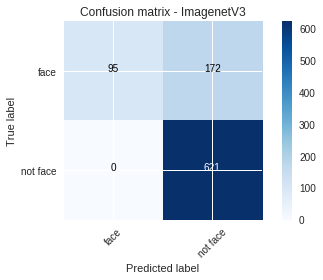

In [0]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['face', 'not face'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

In [0]:
f1_score(y_test, predictions_transfer)

array([[0.9987519]], dtype=float32)

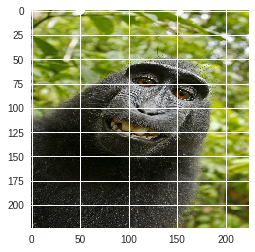

In [0]:
predictoneimage_cnn(imagenet_model, 'testing/monkey.jpg')

array([[0.00779426]], dtype=float32)

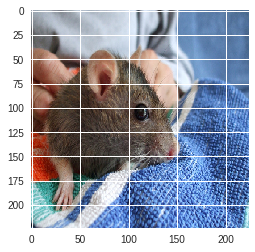

In [0]:
predictoneimage_cnn(imagenet_model, 'data/not_face/10-a.jpg')

### VGG16

In [0]:
from keras.applications import VGG16

In [0]:
vgg16=VGG16(weights='imagenet',include_top=False)
vgg16_new=vgg16.output
vgg16_new=GlobalAveragePooling2D()(vgg16_new)
vgg16_new=Dense(1024,activation='relu')(vgg16_new) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg16_new=Dense(1024,activation='relu')(vgg16_new) #dense layer 2
vgg16_new=Dense(512,activation='relu')(vgg16_new) #dense layer 3
preds=Dense(1,activation='sigmoid')(vgg16_new) #final layer with softmax activation

In [0]:
vgg16_model=Model(inputs=vgg16.input,outputs=preds)

In [0]:
for i,layer in enumerate(vgg16_model.layers[19:]):
  print(i,layer.name)

In [0]:
# or if we want to set the first 19 layers of the network to be non-trainable
for layer in vgg16_model.layers[:19]:
    layer.trainable=False
for layer in vgg16_model.layers[19:]:
    layer.trainable=True

In [0]:
vgg16_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

vgg16_model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, y_val))

In [0]:
vgg16_model.evaluate(X_test, y_test)

In [0]:
predictions_vgg16 = vgg16_model.predict(X_test)
predictions_vgg16 = np.around(predictions_vgg16 )

In [0]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_vgg16), classes=['hot dog', 'not hot dog'], normalize=False,
                      title='Confusion matrix - VGG16')

In [0]:
f1_score(y_test, predictions_vgg16)

## Predict A Single Image

In [0]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

In [0]:
def predictoneimage_dense(path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    
    img = img/255
    img = img.reshape(-1)
    img = np.expand_dims(img, axis=0)
    predict = dense.predict(img)
    return predict

In [0]:
def predictoneimage_dense_1(path):
    img = load_img(path, target_size=(ph_size, ph_size))
    plt.imshow(img)
    img = img_to_array(img)
    
    img = img/255
    img = img.reshape(-1)
    img = np.expand_dims(img, axis=0)
    
    test_img = scaler.transform(img)
    pca_img = pca.transform(test_img)
    predict = dense.predict(pca_img)
    return predict

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Deep Face Verification with Keras

In [0]:
from keras.layers import ZeroPadding2D, Convolution2D,MaxPooling2D, Dropout,Flatten, Activation

In [0]:
model = models.Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [0]:
!ls

adc.json  data	sample_data  testing


In [0]:
from keras.models import model_from_json
from keras.models import load_model
vgg_face = model.load_weights('vgg_face_weights.h5')
# vgg_face = load_model('vgg_face_weights.h5')

In [0]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [0]:
img1_representation = vgg_face_descriptor.predict(preprocess_image('data/face/Denzel_Washington_cropped.jpg'))[0,:]
img2_representation = vgg_face_descriptor.predict(preprocess_image('data/face/brad_pitt.jpg'))[0,:]

In [0]:
img1_representation
# img2_representation

array([ 2.0535778e-04,  2.1369205e-04,  1.2389114e-04, ...,
       -5.6867288e-05, -1.5401604e-04, -3.7919777e-05], dtype=float32)

In [0]:
def findCosineDistance(source_representation, test_representation):
  a = np.matmul(np.transpose(source_representation), test_representation)
  b = np.sum(np.multiply(source_representation, source_representation))
  c = np.sum(np.multiply(test_representation, test_representation))
  return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
  euclidean_distance = source_representation - test_representation
  euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
  euclidean_distance = np.sqrt(euclidean_distance)
  return euclidean_distance

In [0]:
epsilon = 0.40 #cosine similarity
# epsilon = 120 #euclidean distance
 
def verifyFace(img1, img2):
  img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
  img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]
  
  plt.subplot(2,1,1)
  plt.imshow(load_img(img1,target_size=(224,244)))
  plt.subplot(2,1,2)
  plt.imshow(load_img(img2,target_size=(224,244)))
  cosine_similarity = findCosineDistance(img1_representation, img2_representation)
  euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
  
  if(cosine_similarity < 0.4):
    print("verified... they are same person")
  else:
    print("unverified! they are not same person!")

verified... they are same person


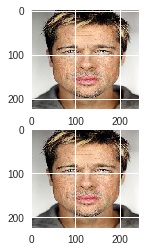

In [0]:
verifyFace('data/face/brad_pitt_hair.jpg','data/face/brad_pitt_hair.jpg')

unverified! they are not same person!


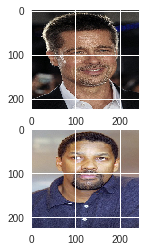

In [0]:
verifyFace('testing/bradpitt.jpg','data/face/Denzel_Washington_cropped.jpg')

unverified! they are not same person!


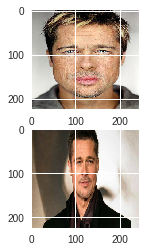

In [0]:
verifyFace('data/face/brad_pitt_hair.jpg','data/face/brad_pitt.jpg')

verified... they are same person


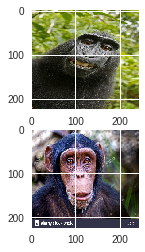

In [0]:
verifyFace('testing/monkey.jpg','testing/monkey2.jpg')

verified... they are same person


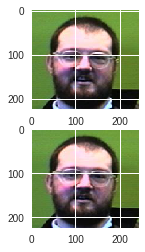

In [0]:
verifyFace('data/face/9326871.1.jpg','data/face/9326871.10.jpg')

unverified! they are not same person!


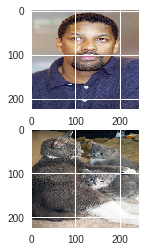

In [0]:
verifyFace('data/face/Denzel_Washington_cropped.jpg','data/not_face/972-a.jpg')